#Image GPT Bias Analysis w/ Hugging Face
Ryan Steed

Adapted from https://colab.research.google.com/github/apeguero1/image-gpt/blob/master/Transformers_Image_GPT.ipynb


## Download Model

In [1]:
!nvidia-smi #OpenAI says you need 16GB GPU for the large model, but it may work if you lower n_sub_batch on the others.

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [2]:
!git clone https://github.com/openai/image-gpt.git

Cloning into 'image-gpt'...
remote: Enumerating objects: 41, done.
remote: Total 41 (delta 0), reused 0 (delta 0), pack-reused 41
Unpacking objects: 100% (41/41), done.


In [3]:
model_sizes = ["s", "m", "l"] #small medium large, xl not available
model_size = "s"
models_dir = "/content/models"
color_clusters_dir = "/content/clusters"
n_px = 32

In [4]:
!python image-gpt/download.py --model {model_size} --ckpt 1000000 --clusters --download_dir {models_dir}/{model_size}
!python image-gpt/download.py --clusters --download_dir {color_clusters_dir}

input args:
 {
    "download_dir":"/content/models/s",
    "model":"s",
    "ckpt":"1000000",
    "clusters":true,
    "dataset":null
}
Fetching model.ckpt-1000000.data-00000-of-00032: 1.00kit [00:00, 687kit/s]      
Fetching model.ckpt-1000000.data-00001-of-00032: 31.5Mit [00:00, 67.4Mit/s]     
Fetching model.ckpt-1000000.data-00002-of-00032: 28.3Mit [00:00, 65.8Mit/s]     
Fetching model.ckpt-1000000.data-00003-of-00032: 28.3Mit [00:00, 68.4Mit/s]     
Fetching model.ckpt-1000000.data-00004-of-00032: 28.3Mit [00:00, 64.0Mit/s]     
Fetching model.ckpt-1000000.data-00005-of-00032: 31.5Mit [00:00, 56.9Mit/s]     
Fetching model.ckpt-1000000.data-00006-of-00032: 30.4Mit [00:00, 57.9Mit/s]     
Fetching model.ckpt-1000000.data-00007-of-00032: 28.3Mit [00:00, 70.5Mit/s]     
Fetching model.ckpt-1000000.data-00008-of-00032: 31.5Mit [00:00, 66.8Mit/s]     
Fetching model.ckpt-1000000.data-00009-of-00032: 29.4Mit [00:00, 58.2Mit/s]     
Fetching model.ckpt-1000000.data-00010-of-00032: 31.5M

## HuggingFace Implementation



In [5]:
import os

!pip install transformers
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

     |████████████████████████████████| 778kB 2.8MB/s 
     |████████████████████████████████| 3.0MB 14.5MB/s 
     |████████████████████████████████| 890kB 33.4MB/s 
     |████████████████████████████████| 1.1MB 51.1MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893257 sha256=7e904f44478b4806abae0dbe6c872b12da918d69b81d824145eb95d8a511399e
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [6]:
import os
import transformers
from transformers.modeling_gpt2 import GPT2Model,GPT2LMHeadModel
import torch
import torch.nn as nn
import logging
logger = logging.getLogger(__name__)

def load_tf_weights_in_image_gpt2(model, config, gpt2_checkpoint_path):
    """ Load tf checkpoints in a pytorch model
    """
    try:
        import re
        import tensorflow as tf
    except ImportError:
        logger.error(
            "Loading a TensorFlow model in PyTorch, requires TensorFlow to be installed. Please see "
            "https://www.tensorflow.org/install/ for installation instructions."
        )
        raise
    tf_path = os.path.abspath(gpt2_checkpoint_path)
    logger.info("Converting TensorFlow checkpoint from {}".format(tf_path))
    # Load weights from TF model
    init_vars = tf.train.list_variables(tf_path)
    names = []
    arrays = []

    for name, shape in init_vars:
        logger.info("Loading TF weight {} with shape {}".format(name, shape))
        array = tf.train.load_variable(tf_path, name)
        names.append(name)
        arrays.append(array.squeeze())

    for name, array in zip(names, arrays):
        name = name[6:]  # skip "model/"
        name = name.split("/")

        # adam_v and adam_m are variables used in AdamWeightDecayOptimizer to calculated m and v
        # which are not required for using pretrained model
        if any(
            n in ["adam_v", "adam_m", "AdamWeightDecayOptimizer", "AdamWeightDecayOptimizer_1", "global_step"]
            for n in name
        ) or name[-1] in ['_step']:
            logger.info("Skipping {}".format("/".join(name)))
            continue
        
        pointer = model
        if name[-1] not in ["wtet"]:
          pointer = getattr(pointer, "transformer")
        
        for m_name in name:
            if re.fullmatch(r"[A-Za-z]+\d+", m_name):
                scope_names = re.split(r"(\d+)", m_name)
            else:
                scope_names = [m_name]

            if scope_names[0] == "w" or scope_names[0] == "g":
                pointer = getattr(pointer, "weight")
            elif scope_names[0] == "b":
                pointer = getattr(pointer, "bias")
            elif scope_names[0] == "wpe" or scope_names[0] == "wte":
                pointer = getattr(pointer, scope_names[0])
                pointer = getattr(pointer, "weight")
            elif scope_names[0] in ['q_proj','k_proj','v_proj']:
                pointer = getattr(pointer, 'c_attn')
                pointer = getattr(pointer, 'weight')
            elif len(name) ==3 and name[1]=="attn" and scope_names[0]=="c_proj":
                pointer = getattr(pointer, scope_names[0])
                pointer = getattr(pointer, 'weight')
            elif scope_names[0]=="wtet":
                pointer = getattr(pointer, "lm_head")
                pointer = getattr(pointer, 'weight')
            elif scope_names[0]=="sos":
                pointer = getattr(pointer,"wte")
                pointer = getattr(pointer, 'weight')
            else:
                pointer = getattr(pointer, scope_names[0])
            if len(scope_names) >= 2:
                num = int(scope_names[1])
                pointer = pointer[num]

        if len(name) > 1 and name[1]=="attn" or name[-1]=="wtet" or name[-1]=="sos" or name[-1]=="wte":
           pass #array is used to initialize only part of the pointer so sizes won't match
        else:
          try:
              assert pointer.shape == array.shape
          except AssertionError as e:
              e.args += (pointer.shape, array.shape)
              raise
          
        logger.info("Initialize PyTorch weight {}".format(name))

        if name[-1]=="q_proj":
          pointer.data[:,:config.n_embd] = torch.from_numpy(array.reshape(config.n_embd,config.n_embd) ).T
        elif name[-1]=="k_proj":
          pointer.data[:,config.n_embd:2*config.n_embd] = torch.from_numpy(array.reshape(config.n_embd,config.n_embd) ).T
        elif name[-1]=="v_proj":
          pointer.data[:,2*config.n_embd:] = torch.from_numpy(array.reshape(config.n_embd,config.n_embd) ).T
        elif (len(name) ==3 and name[1]=="attn" and name[2]=="c_proj" ):
          pointer.data = torch.from_numpy(array.reshape(config.n_embd,config.n_embd) )
        elif name[-1]=="wtet":
          pointer.data = torch.from_numpy(array)
        elif name[-1]=="wte":
          pointer.data[:config.vocab_size-1,:] = torch.from_numpy(array)
        elif name[-1]=="sos":
          pointer.data[-1] = torch.from_numpy(array)
        else:
          pointer.data = torch.from_numpy(array)

    return model


from torch.nn.parameter import Parameter
class ln_mod(nn.Module):
    def __init__(self, nx,eps=1e-5):
        super().__init__()
        self.eps = eps
        self.weight = Parameter(torch.Tensor(nx))
    def forward(self,x):#input is not mean centered
        return x / torch.sqrt( torch.std(x,axis=-1,unbiased=False,keepdim=True)**2 + self.eps ) * self.weight.data[...,:] 

def replace_ln(m, name,config):
  for attr_str in dir(m):
      target_attr = getattr(m, attr_str)
      if type(target_attr) == torch.nn.LayerNorm:
          #print('replaced: ', name, attr_str)
          setattr(m, attr_str, ln_mod(config.n_embd,config.layer_norm_epsilon))

  for n, ch in m.named_children():
      replace_ln(ch, n,config)        

def gelu2(x):
    return x * torch.sigmoid(1.702 * x)

class ImageGPT2LMHeadModel(GPT2LMHeadModel):
  load_tf_weights = load_tf_weights_in_image_gpt2
  
  def __init__(self, config):
      super().__init__(config)
      self.lm_head = nn.Linear(config.n_embd, config.vocab_size - 1, bias=False)
      replace_ln(self,"net",config) #replace layer normalization
      for n in range(config.n_layer):
        self.transformer.h[n].mlp.act = gelu2 #replace activation 

  def tie_weights(self): #image-gpt doesn't tie output and input embeddings
    pass 

In [7]:
import numpy as np
color_clusters_file = "%s/kmeans_centers.npy"%(color_clusters_dir)
clusters = np.load(color_clusters_file) #get color clusters

In [8]:
MODELS={"l":(1536,16,48),"m":(1024,8,36),"s":(512,8,24) } 
n_embd,n_head,n_layer=MODELS[model_size] #set model hyperparameters
vocab_size = len(clusters) + 1 #add one for start of sentence token
config = transformers.GPT2Config(vocab_size=vocab_size,n_ctx=n_px*n_px,n_positions=n_px*n_px,n_embd=n_embd,n_layer=n_layer,n_head=n_head)
model_path = "%s/%s/model.ckpt-1000000.index"%(models_dir,model_size)

model = ImageGPT2LMHeadModel.from_pretrained(model_path,from_tf=True,config=config)

## Image Utils

In [9]:
#Resize original images to n_px by n_px
import cv2
import numpy as np

#numpy implementation of functions in image-gpt/src/utils which convert pixels of image to nearest color cluster. 
def normalize_img(img):
  return img/127.5 - 1

def squared_euclidean_distance_np(a,b):
  b = b.T
  a2 = np.sum(np.square(a),axis=1)
  b2 = np.sum(np.square(b),axis=0)
  ab = np.matmul(a,b)
  d = a2[:,None] - 2*ab + b2[None,:]
  return d

def color_quantize_np(x, clusters):
    x = x.reshape(-1, 3)
    d = squared_euclidean_distance_np(x, clusters)
    return np.argmin(d,axis=1)

def resize(image_paths, rotate_90=False):
  dim=(n_px,n_px)
  x = np.zeros((len(image_paths),n_px,n_px,3),dtype=np.uint8)

  for n,image_path in enumerate(image_paths):
    img_np = cv2.imread(image_path)   # reads an image in the BGR format
    img_np = cv2.cvtColor(img_np, cv2.COLOR_BGR2RGB)   # BGR -> RGB
    H,W,C = img_np.shape
    D = min(H,W)
    img_np = img_np[:D,:D,:C] #get square piece of image
    if (rotate_90):
      img_np = cv2.rotate(img_np, cv2.cv2.ROTATE_90_CLOCKWISE)
    x[n] = cv2.resize(img_np,dim, interpolation = cv2.INTER_AREA) #resize to n_px by n_px

  return x

## Embedding Extraction

Prior implementations:
- SENT (w/ jiant) - https://github.com/W4ngatang/sent-bias
- Tan & Celis (w/ HuggingFace) - https://github.com/tanyichern/social-biases-contextualized

In [37]:
# a couple example sets
## tools
!curl https://implicit.harvard.edu/implicit/user/demo.us/demo.weapons.0003/images/hbottle.jpg > bottle.jpg
!curl https://implicit.harvard.edu/implicit/user/demo.us/demo.weapons.0003/images/hcamera.jpg > camera.jpg
!curl https://implicit.harvard.edu/implicit/user/demo.us/demo.weapons.0003/images/hcoke.jpg > coke.jpg
!curl https://implicit.harvard.edu/implicit/user/demo.us/demo.weapons.0003/images/hice_cream.jpg > icecream.jpg
!curl https://implicit.harvard.edu/implicit/user/demo.us/demo.weapons.0003/images/hphone.jpg > phone.jpg
!curl https://implicit.harvard.edu/implicit/user/demo.us/demo.weapons.0003/images/hwalkman.jpg > walkman.jpg
!curl https://implicit.harvard.edu/implicit/user/demo.us/demo.weapons.0003/images/hwallet.jpg > wallet.jpg
tools = ["bottle.jpg", "camera.jpg", "coke.jpg", "icecream.jpg", "phone.jpg", "walkman.jpg", "wallet.jpg"]
## weapons
!curl https://implicit.harvard.edu/implicit/user/demo.us/demo.weapons.0003/images/waxe.jpg > axe.jpg
!curl https://implicit.harvard.edu/implicit/user/demo.us/demo.weapons.0003/images/wcannon.jpg > cannon.jpg
!curl https://implicit.harvard.edu/implicit/user/demo.us/demo.weapons.0003/images/wgrenade.jpg > grenade.jpg
!curl https://implicit.harvard.edu/implicit/user/demo.us/demo.weapons.0003/images/wmace.jpg > mace.jpg
!curl https://implicit.harvard.edu/implicit/user/demo.us/demo.weapons.0003/images/wrevolver.jpg > revolver.jpg
!curl https://implicit.harvard.edu/implicit/user/demo.us/demo.weapons.0003/images/wrifle.jpg > rifle.jpg
!curl https://implicit.harvard.edu/implicit/user/demo.us/demo.weapons.0003/images/wsword.jpg > sword.jpg
weapons = ["axe.jpg", "cannon.jpg", "grenade.jpg", "mace.jpg", "revolver.jpg", "rifle.jpg", "sword.jpg"]
## black people
!curl https://implicit.harvard.edu/implicit/user/demo.us/demo.weapons.0003/images/bf14.jpg > bf14.jpg
!curl https://implicit.harvard.edu/implicit/user/demo.us/demo.weapons.0003/images/bf23.jpg > bf23.jpg
!curl https://implicit.harvard.edu/implicit/user/demo.us/demo.weapons.0003/images/bf56.jpg > bf56.jpg
!curl https://implicit.harvard.edu/implicit/user/demo.us/demo.weapons.0003/images/bm14.jpg > bm14.jpg
!curl https://implicit.harvard.edu/implicit/user/demo.us/demo.weapons.0003/images/bm23.jpg > bm23.jpg
!curl https://implicit.harvard.edu/implicit/user/demo.us/demo.weapons.0003/images/bm56.jpg > bm56.jpg
black_people = ["bf14.jpg", "bf23.jpg", "bf56.jpg", "bm14.jpg", "bm23.jpg", "bm56.jpg"]

!curl https://implicit.harvard.edu/implicit/user/demo.us/demo.weapons.0003/images/wf2.jpg > wf2.jpg
!curl https://implicit.harvard.edu/implicit/user/demo.us/demo.weapons.0003/images/wf3.jpg > wf3.jpg
!curl https://implicit.harvard.edu/implicit/user/demo.us/demo.weapons.0003/images/wf6.jpg > wf6.jpg
!curl https://implicit.harvard.edu/implicit/user/demo.us/demo.weapons.0003/images/wm1.jpg > wm1.jpg
!curl https://implicit.harvard.edu/implicit/user/demo.us/demo.weapons.0003/images/wm4.jpg > wm4.jpg
!curl https://implicit.harvard.edu/implicit/user/demo.us/demo.weapons.0003/images/wm6.jpg > wm6.jpg
white_people = ["wf2.jpg", "wf3.jpg", "wf6.jpg", "wm1.jpg", "wm4.jpg", "wm6.jpg"]

image_paths = tools + weapons + black_people + white_people

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5201  100  5201    0     0  40007      0 --:--:-- --:--:-- --:--:-- 40007
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  7363  100  7363    0     0  57077      0 --:--:-- --:--:-- --:--:-- 57077
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6533  100  6533    0     0  89493      0 --:--:-- --:--:-- --:--:-- 89493
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6358  100  6358    0     0  48534      0 --:--:-- --:--:-- --:--:-- 48534
  % Total    % Received % Xferd  Average Speed   Tim

NameError: ignored

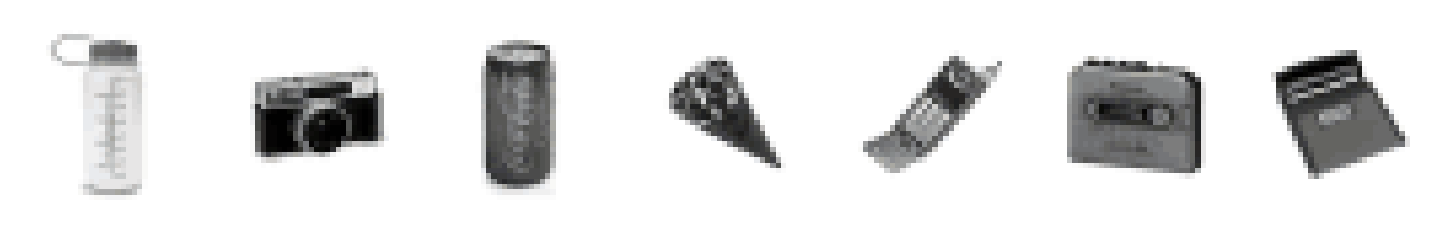

In [11]:
import matplotlib.pyplot as plt

x = resize(image_paths)
x_norm = normalize_img(x) #normalize pixels values to -1 to +1
samples = color_quantize_np(x_norm,clusters).reshape(x_norm.shape[:-1]) #map pixels to closest color cluster
samples_img = [np.reshape(np.rint(127.5 * (clusters[s] + 1.0)), [n_px, n_px, 3]).astype(np.uint8) for s in samples] # convert color clusters back to pixels
f, axes = plt.subplots(1,len(image_paths),dpi=300)
for img, ax in zip(samples_img, axes):
  ax.axis('off')
  ax.imshow(img)

In [23]:
with torch.no_grad(): # saves some memory
  # initialize with SOS token
  context = np.concatenate( 
      (
          np.full( (len(image_paths), 1), vocab_size - 1 ),
          samples.reshape(-1,n_px*n_px),
      ), axis=1 
  )
  # DEBUG THIS LATER
  # must drop the last pixel to make room for the SOS
  context = torch.tensor(context[:,:-1])
  enc, _ = model(context)
  enc_last = enc[:, -1, :].numpy()  # extract the rep of the last input, as in sent-bias
  np.savetxt("encs.csv", enc_last, delimiter=',')

In [33]:
import pandas as pd

# add the image names to the CSV file
df = pd.read_csv("encs.csv", header=None)
df["img"] = image_paths
df.to_csv("encs_labeled.csv")

In [34]:
from google.colab import files

files.download("encs_labeled.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>